In [ ]:
!unzip ChartFC.zip

Archive:  ChartFC.zip
   creating: ChartFC/
  inflating: ChartFC/Mexico_survey_barrier_09.png  
  inflating: ChartFC/Line_Graph_GDP_and_Year.png  
  inflating: ChartFC/Distribution_of_ethnic_groups_in_Crimea_2001.png  
  inflating: ChartFC/Aidsproposalinfographic_(8496955907).jpg  
  inflating: ChartFC/2019_States_with_most_firearm_background_checks_per_100,000_people.png  
  inflating: ChartFC/PPTCountdowntoSingularityLinear.jpg  
  inflating: ChartFC/Ghg_pie_chart_Turkey.png  
  inflating: ChartFC/Solicitation_graph.jpg  
  inflating: ChartFC/US_male_arrests_for_liquor_laws_by_age.png  
  inflating: ChartFC/Regional_Profile_of_the_East_of_England.png  
  inflating: ChartFC/Change_in_death_rate_on_8000ers_from_before_1990_to_1990_-_2003.png  
  inflating: ChartFC/1850-2019_Cumulative_greenhouse_gas_emissions_by_region_-_bar_chart_-_IPCC_AR6_WG3_-_Fig_SPM.2b.png  
  inflating: ChartFC/House_prices_in_Layer_Breton_2017_.gif  
  inflating: ChartFC/Michiel1972edits.PNG  
  inflating: Char

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install evaluate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
import json
from PIL import Image
import os
import torch
from itertools import cycle
from evaluate import load
from tqdm import tqdm
import pickle
from google.colab import files

In [ ]:
model = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-chartqa")
processor = AutoProcessor.from_pretrained("google/matcha-chartqa")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
with open("claim_explanation_verification_pre_tasksets.json", "r") as f:
  data = json.load(f)

In [ ]:
for example in data:
  example["label"] = "Yes" if example["label"] == "TRUE" else "No"

In [ ]:
new_data = []
for example in data:
  try:
    imgname = os.path.basename(example["chart_img"])
    Image.open(f"ChartFC/{imgname}").convert('RGB')
    new_data.append(example)
  except Exception:
    pass

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
data=np.array(new_data)

In [ ]:
np.random.seed(42)

# Shuffle the indices of the data
indices = np.random.permutation(len(data))

# Calculate the number of samples in the training, validation, and testing sets
num_train = int(0.8 * len(data))
num_val = int(0.1 * len(data))

# Split the indices into training, validation, and testing sets
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train+num_val]
test_indices = indices[num_train+num_val:]

In [ ]:
train_data = data[train_indices]
val_data = data[val_indices]
test_data = data[test_indices]

In [ ]:
len(train_data)

5830

In [ ]:
MAX_PATCHES = 2048

class ChartFCDataset(Dataset):
    def __init__(self, processor, root_dir="ChartFC", split='train'):
        """
        Args:
            root_dir (string): Directory with all the ChartQA data.
            split (string): Which split to load ("train" or "val" or "test").
            split2 (string): Which split to load ("both" or "augmented" or "human") within the first split.
        """
        self.processor = processor
        self.root_dir = root_dir
        self.split = split
        self.image_dir = root_dir

        if split == 'train':
          self.data = train_data
        elif split=="val":
          self.data = val_data
        elif split == "test":
          self.data = test_data
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        qa = self.data[idx]
        # Load image
        imgname = os.path.basename(qa["chart_img"])
        qa["imgname"] = imgname
        qa["image"] = Image.open(f"{self.image_dir}/{imgname}").convert('RGB')
        return qa

In [ ]:
question = f"is the following claim supported by the chart:"

In [ ]:
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  images = [item["image"] for item in batch]
  header_texts = [f"{question} {item['claim']} (Yes/No)" for item in batch]
  label_texts = [f"{item['label']}" for item in batch] # because {item['explanation']}
  
  inputs = processor(images=images, text=header_texts, return_tensors="pt")
  labels = processor.tokenizer(label_texts, padding="max_length", return_tensors="pt", max_length=256)
  new_batch["labels"] = labels.input_ids
  new_batch["flattened_patches"] = inputs["flattened_patches"]
  new_batch["attention_mask"] = inputs["attention_mask"]
  new_batch["header_texts"] = header_texts
  new_batch["imgname"] = [item["imgname"] for item in batch]


  return new_batch

In [ ]:
batch_size = 1

In [ ]:
train_dataset = ChartFCDataset(processor, split='train')
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collator)

In [ ]:
model.to(device);

In [ ]:
exact_match_metric = load("exact_match")

In [ ]:
model.eval()

accuracy = []
predictions = []
for idx, batch in tqdm(enumerate(train_dataloader)):
  labels = batch.pop("labels").to(device)
  flattened_patches = batch.pop("flattened_patches").to(device)
  attention_mask = batch.pop("attention_mask").to(device)
  imgname = batch.pop("imgname")[0]
  header_text = batch.pop("header_texts")[0]

  generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=128)
  predicted_answer = processor.tokenizer.batch_decode(generated_ids,skip_special_tokens=True)
  label = processor.tokenizer.batch_decode(labels,skip_special_tokens=True)
  predictions.append({"imgname":imgname, "query":header_text, "generated_ids":  generated_ids.cpu()[0].numpy(), "decoded_answer": predicted_answer[0], "label":label[0]})
  metric = exact_match_metric.compute(predictions=predicted_answer, references=label)
  accuracy.append(metric["exact_match"])

5830it [51:05,  1.90it/s]


In [ ]:
with open('accuracy_chartqa_new_prompt.pkl', 'wb') as f:
  pickle.dump(accuracy, f)

In [ ]:
files.download('accuracy_chartqa_new_prompt.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('predictions_chartqa_new_prompt.pkl', 'wb') as f:
  pickle.dump(predictions, f)

In [ ]:
files.download('predictions_chartqa_new_prompt.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open("accuracy_plotqav2.pkl", "rb") as f:
  a = pickle.load(f)

In [ ]:
with open("predictions_plotqav2.pkl", "rb") as f:
  predictions = pickle.load(f)

In [ ]:
sum(accuracy)/len(accuracy)

0.5039451114922813

In [ ]:
sum([int(item['label'] == item['decoded_answer']) for item in predictions])/len(predictions)

0.5039451114922813

In [ ]:
len(set([item['imgname'] for item in predictions]))

1621

In [ ]:
with open("barchart_horizontal.json", "r") as f:
  bar_horizontal = json.load(f)[0]

In [ ]:
bar_horizontal = set([os.path.splitext(i["file_name"])[0] for i in bar_horizontal])

In [ ]:
with open("barchart_vertical.json", "r") as f:
  bar_vertical = json.load(f)[0]

In [ ]:
bar_vertical = set([os.path.splitext(i["file_name"])[0] for i in bar_vertical])

In [ ]:
with open("line_chart.json", "r") as f:
  line_chart = json.load(f)[0]

In [ ]:
line_chart = set([os.path.splitext(i["file_name"])[0] for i in line_chart])

In [ ]:
with open("pie_chart.json", "r") as f:
  pie_chart = json.load(f)[0]

In [ ]:
pie_chart = set([os.path.splitext(i["file_name"])[0] for i in pie_chart])

In [ ]:
for item in predictions:
  filename = os.path.splitext(item['imgname'])[0]
  key = filename
  set1 = bar_horizontal
  set2 = bar_vertical
  set3 = line_chart
  set4 = pie_chart
  if key in set1 and key not in set2 and key not in set3 and key not in set4:
    item["chart_type"] = "bar_horizontal"
  elif key not in set1 and key in set2 and key not in set3 and key not in set4:
    item["chart_type"] = "bar_vertical"
  elif key not in set1 and key not in set2 and key in set3 and key not in set4:
    item["chart_type"] = "line_chart"
  elif key not in set1 and key not in set2 and key not in set3 and key in set4:
    item["chart_type"] = "pie_chart"
  else:
    item["chart_type"] = "mixed"

In [ ]:
accuracy_by_category = {"bar_horizontal":[], "bar_vertical":[],"line_chart":[],"pie_chart":[],"mixed":[]}

for item in predictions:
  metric = int(item["decoded_answer"] == item["label"])
  accuracy_by_category[item["chart_type"]].append(metric)

In [ ]:
accuracy_len = {}
for key , v in accuracy_by_category.items():
  accuracy_len[key] = len(v)

In [ ]:
accuracy_len

{'bar_horizontal': 517,
 'bar_vertical': 1367,
 'line_chart': 1624,
 'pie_chart': 2310,
 'mixed': 12}

In [ ]:
accuracy_bins = {}
for key , v in accuracy_by_category.items():
  accuracy_bins[key] = sum(v)/len(v)

In [ ]:
accuracy_bins

{'bar_horizontal': 0.0,
 'bar_vertical': 0.0,
 'line_chart': 0.0,
 'pie_chart': 0.0,
 'mixed': 0.0}

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.DataFrame.from_dict(accuracy_len, orient='index', columns=['count'])

Text(0.5, 0, 'Chart type')

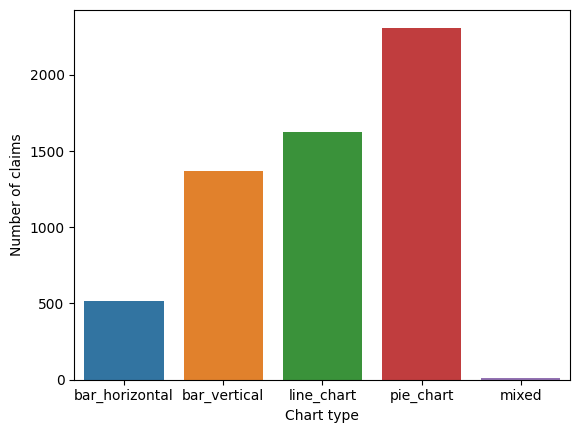

In [ ]:
sns.barplot(x=df.index, y='count', data=df, orient='v', )
plt.ylabel('Number of claims')
plt.xlabel('Chart type')

In [ ]:
df = pd.DataFrame.from_dict(accuracy_bins, orient='index', columns=['accuracy'])

Text(0.5, 0, 'Chart type')

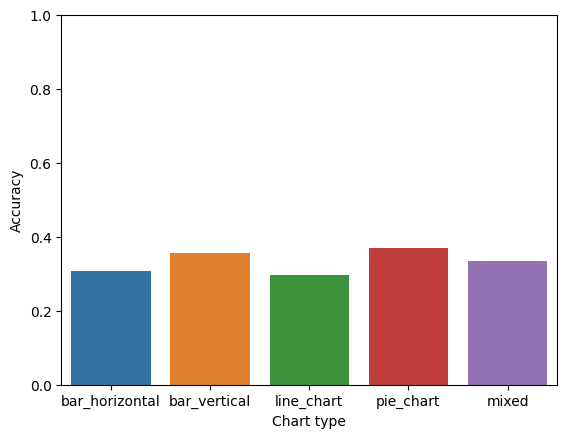

In [ ]:
ax = sns.barplot(x=df.index, y='accuracy', data=df, orient='v', )
ax.set(ylim=(0, 1))
plt.ylabel('Accuracy')
plt.xlabel('Chart type')

In [ ]:
chart_bins = {"bar_horizontal":0, "bar_vertical":0,"line_chart":0,"pie_chart":0,"mixed":0}
found = set()
for item in predictions:
  filename = os.path.splitext(item['imgname'])[0]
  if filename not in found:
    chart_bins[item["chart_type"]]+=1
    found.add(filename)

In [ ]:
df = pd.DataFrame.from_dict(chart_bins, orient='index', columns=['count'])

Text(0.5, 0, 'Chart type')

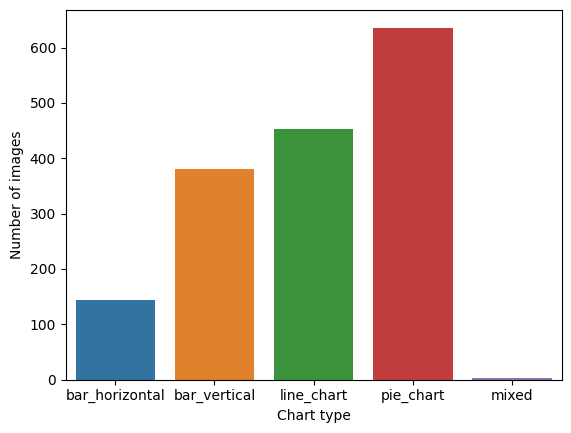

In [ ]:
sns.barplot(x=df.index, y='count', data=df, orient='v', )
plt.ylabel('Number of images')
plt.xlabel('Chart type')